In [1]:
!unzip /content/drive/MyDrive/colab/img_ds/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [1]:
!mkdir dataset
!mv seg_train/seg_train/* dataset/
!mv seg_test/seg_test/buildings dataset/buildings
!mv seg_test/seg_test/forest dataset/forest
!mv seg_test/seg_test/glacier dataset/glacier
!mv seg_test/seg_test/mountain dataset/mountain
!mv seg_test/seg_test/sea dataset/sea
!mv seg_test/seg_test/street dataset/street

We merge train and val datasets from original archive and rearrange then randomly on our side

In [19]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

In [5]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    'dataset',
    image_size=(150, 150),
    label_mode="int",
    # labels='inferred',
    subset='both',
    shuffle=True,
    seed=123,
    validation_split=0.15,
)


Found 17034 files belonging to 6 classes.
Using 14479 files for training.
Using 2555 files for validation.


In [6]:
norm_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_dataset = train_dataset.map(lambda x, y: (norm_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (norm_layer(x), y))

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

In [8]:
normalized_train_dataset_additional = normalized_train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [9]:
normalized_train_dataset = normalized_train_dataset.concatenate(normalized_train_dataset_additional)

In [11]:
normalized_train_dataset = normalized_train_dataset.shuffle(normalized_train_dataset.cardinality())
normalized_train_dataset = normalized_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
class SimpleConvLayer(tf.keras.models.Model):
    def __init__(self, filters, kernel=(3, 3,), pool_size=(3, 3), padding='same', activation='relu', dropout_rate=0.1):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel, padding=padding, activation=activation)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=pool_size)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)


    def call(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.dropout(x)
        return x

In [13]:
class DenseLayer(tf.keras.models.Model):
    def __init__(self, units, activation='relu', dropout=0.1):
        super().__init__()
        self.dense = tf.keras.layers.Dense(units=units, activation=activation)
        self.dropout = tf.keras.layers.Dropout(rate=dropout)


    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        return x

In [14]:
class SlideConvolution(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = SimpleConvLayer(filters=32, kernel=(3, 3,), dropout_rate=0.3, pool_size=(3, 3), padding='valid',)
        self.conv_layer_2 = SimpleConvLayer(filters=64, kernel=(3, 3,), dropout_rate=0.3, pool_size=(3, 3),padding='valid',)
        self.conv_layer_3 = SimpleConvLayer(filters=128, kernel=(3, 3,), dropout_rate=0.3, pool_size=(3, 3),padding='valid',)

        self.dense_layer_1 = DenseLayer(units=128, dropout=0.3)
        self.dense_layer_2 = DenseLayer(units=64, dropout=0.3)
        self.dense_layer_3 = DenseLayer(units=32, dropout=0.3)
        self.dense_layer_4 = DenseLayer(units=16, dropout=0.3)

        self.flatten_1 = tf.keras.layers.Flatten()
        self.flatten_2 = tf.keras.layers.Flatten()
        self.flatten_3 = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(6)


    def call(self, x):
        x = self.conv_layer_1(x)
        x_conv_1 = self.flatten_1(x)

        x = self.conv_layer_2(x)
        x_conv_2 = self.flatten_2(x)

        x = self.conv_layer_3(x)
        x_conv_3 = self.flatten_3(x)

        x = self.dense_layer_1(x_conv_1)

        x = tf.keras.layers.Concatenate()([x, x_conv_2])
        x = self.dense_layer_2(x)

        x = tf.keras.layers.Concatenate()([x, x_conv_3])
        x = self.dense_layer_3(x)
        x = self.dense_layer_4(x)
        x = self.out(x)
        return x

This model is relatively small. Increase in the number of logs will increase the accuracy on the save dataset


In [15]:
model = SlideConvolution()
for image_batch, labels_batch in normalized_train_dataset.take(1):
  model(image_batch)
  break
model.summary()

Model: "slide_convolution"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_conv_layer (SimpleC  multiple                  896       
 onvLayer)                                                       
                                                                 
 simple_conv_layer_1 (Simpl  multiple                  18496     
 eConvLayer)                                                     
                                                                 
 simple_conv_layer_2 (Simpl  multiple                  73856     
 eConvLayer)                                                     
                                                                 
 dense_layer (DenseLayer)    multiple                  9834624   
                                                                 
 dense_layer_1 (DenseLayer)  multiple                  929856    
                                                 

In [16]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_sheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy'],
)

In [17]:
history = model.fit(normalized_train_dataset, epochs=50,
    validation_data=normalized_val_dataset, callbacks=[learning_rate_sheduler_callback]
)

Epoch 1/50
906/906 [==============================] - 61s 23ms/step - loss: 1.5462 - accuracy: 0.3335 - val_loss: 1.1422 - val_accuracy: 0.5980 - lr: 0.0010
Epoch 2/50
906/906 [==============================] - 55s 22ms/step - loss: 1.2165 - accuracy: 0.5214 - val_loss: 0.9407 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 3/50
906/906 [==============================] - 55s 22ms/step - loss: 1.0606 - accuracy: 0.5952 - val_loss: 0.7769 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 4/50
906/906 [==============================] - 55s 22ms/step - loss: 0.9614 - accuracy: 0.6505 - val_loss: 0.7027 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 5/50
906/906 [==============================] - 56s 22ms/step - loss: 0.9051 - accuracy: 0.6769 - val_loss: 0.6660 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 6/50
906/906 [==============================] - 55s 22ms/step - loss: 0.8528 - accuracy: 0.7045 - val_loss: 0.6183 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 7/50
906/906 [==============================] - 55s 

In [18]:
model.save_weights('/content/drive/MyDrive/colab/img_ds/2024-04-25-stack-3')

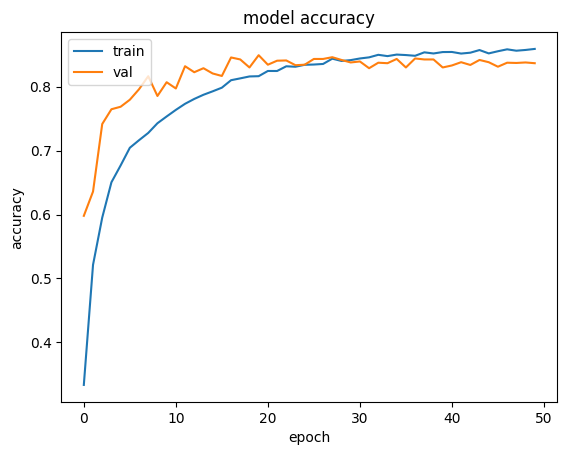

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

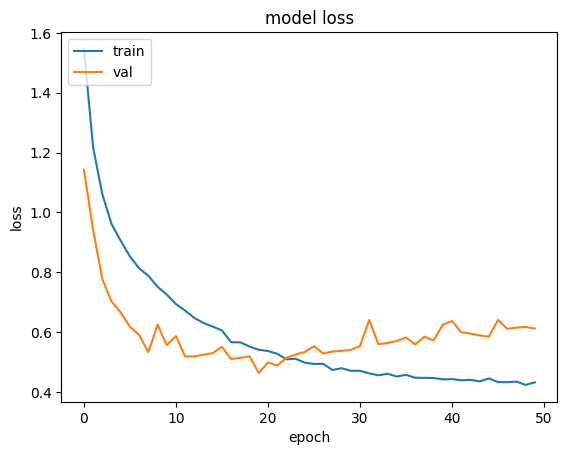

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()